In [1]:
import sys
import os, os.path

sys.path.append(os.path.join(os.getcwd() ,'/modules'))
root_path = "C:/git/Springboard-Public/Capstone Project 2/"
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    root_path = "/content/drive/My Drive/Capstone Project 2/"

print('Current Working Dir: ', os.getcwd())
print('Root Path: ', root_path)

# We need to set the working directory since we are using relative paths from various locations
if os.getcwd() != root_path:
  os.chdir(root_path)

Current Working Dir:  C:\git\Springboard-Public\Capstone Project 2\notebooks\Support Notebooks for Modules
Root Path:  C:/git/Springboard-Public/Capstone Project 2/


In [2]:
import numpy as np
from sklearn import metrics
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from modules.lib.ChextXRayImages import *
from modules.lib.Metrics import *
from modules.models.CustomPneumonia import CustomPneumoniaNN

from PIL import Image
import copy

import torch.optim as optim
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.models as models

from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

%matplotlib inline

In [3]:
force_cpu = True
device = torch.device('cuda' if ~force_cpu and torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device={device}')

Working on device=cuda


In [4]:
loaders = Loaders()
batch_size=16
val_percent=0.15
number_images = 20000
train_loader, val_loader = loaders.getDataTrainValidateLoaders(batch_size=batch_size, 
                                                                        val_percent=val_percent, 
                                                                        n_random_rows=number_images)

target_columns = loaders.target_columns

train_actual = loaders.train_df
val_actual = loaders.val_df

print(f'Number of Training Batches: {len(train_loader):,}')
print(f'Number of Validation Batches: {len(val_loader):,}')
print(f'Number of Training Images: {len(train_loader) * batch_size:,}')
print(f'Number of Validation Images: {len(val_loader) * batch_size:,}')

Number of Training Batches: 1,064
Number of Validation Batches: 187
Number of Training Images: 17,024
Number of Validation Images: 2,992


In [5]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)       
        self.flattened_length_ = 1*320*320
        self.fc1 = nn.Linear(self.flattened_length_, 12)
       
    def forward(self, x):    
        x = x.view(-1, self.flattened_length_)    
        x = self.fc1(x)
        return x

In [6]:
net = SimpleModel()

net = nn.DataParallel(net)
net.to(device)

summary(net, (1, 320, 320)) #Known Harded code size generated by data loaders (todo: make attribute of loaders)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]       1,228,812
       SimpleModel-2                   [-1, 12]               0
Total params: 1,228,812
Trainable params: 1,228,812
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.39
Forward/backward pass size (MB): 0.00
Params size (MB): 4.69
Estimated Total Size (MB): 5.08
----------------------------------------------------------------


In [7]:
learning_rate = 1e-4
num_epochs = 2

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.9)

metrics = Metrics(target_columns, train_actual, val_actual, cc=0)

In [8]:
def parseLoaderData(data):
    """
    The data loaders output a dictionary with 3 keys
    The first 2 keys hold single values for the ImageID and the actual tensor of the image
    The last key holds the ground truth vector of the 12 lables
    """ 
    
    ids, inputs, labels = data['id'], data['img'], data['labels']
    # move data to device GPU OR CPU
    inputs, labels = inputs.to(device), labels.to(device)
    return ids, inputs, labels

In [9]:
def processBatch(net, data, optimizer=None):
    """
    Used for both training and validation.
    Validation will not pass in the optimizer.
    """

    # Convert output from loader
    ids, inputs, labels = parseLoaderData(data)
    
    if optimizer:
        # zero the parameter gradients
        optimizer.zero_grad()
        
    # Convert output to predicitons
    outputs = net(inputs)
    
    return ids, inputs, labels, outputs

In [10]:
def backProp(criterion, outputs, labels, optimizer):
    """
    Get loss value from criterion
    run backprop on the loss
    update weights in optimizer
    update epoch loss
    """
    
    loss = criterion(outputs, labels)#.float())
    loss.backward()
    optimizer.step()
    return loss.item()

In [11]:
epoch_loss = 0
losses_hx = {}

In [12]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    start_time = datetime.now()
    
    
    # Training
    net.train()
    for i, data in enumerate(train_loader, 0):
        ids, inputs, labels, outputs = processBatch(net, data, optimizer)
        metrics.appendEpochBatchData(ids, outputs)
        epoch_loss += backProp(criterion, outputs, labels, optimizer)

    metrics.closeEpoch(i)
    training_time_elapsed = datetime.now()
    start_time = datetime.now()
    
    # Validation
    net.eval()
    with torch.no_grad():
      for data in val_loader:          
            ids, inputs, labels, outputs = processBatch(net, data)
            metrics.appendEpochBatchData(ids, outputs, is_validation=True)
   
    metrics.closeEpoch(i, is_validation=True)
    validation_time_elapsed = datetime.now()
    
    
    # stdout Results
    print('=' * 50 + f'\nEpoch [{epoch+1}/{num_epochs}]\n' + '=' * 50)
    print(f'Epoch Loss: {epoch_loss:.4f} \
\nTraining Time: {training_time_elapsed})  \
\nValidation Time: {validation_time_elapsed})')
    
    metrics.displayMetrics(showMetricDataFrame=False,
                           showROCCurves=False, 
                           showPrecisionRecallCurves=False, 
                           include_targets=['Edema', 'Lung_Opacity', 'Pneumonia'])

Epoch [1/2]
Epoch Loss: 886.4792 
Training Time: 2020-07-11 09:40:12.698821)  
Validation Time: 2020-07-11 09:40:24.799471)

TRAINING



,Score for all Targets
Accuracy Score,0.068670
Hamming Loss,0.191026
Combined Recall,0.213488
Combined Precision,0.231994
Combined F1,0.199770



VALIDATION



,Score for all Targets
Accuracy Score,0.015045
Hamming Loss,0.328402
Combined Recall,0.281405
Combined Precision,0.165386
Combined F1,0.188858


Epoch [2/2]
Epoch Loss: 1795.8607 
Training Time: 2020-07-11 09:41:41.004756)  
Validation Time: 2020-07-11 09:41:53.121342)

TRAINING



,Score for all Targets
Accuracy Score,0.069551
Hamming Loss,0.191208
Combined Recall,0.212307
Combined Precision,0.231258
Combined F1,0.198497



VALIDATION



,Score for all Targets
Accuracy Score,0.008693
Hamming Loss,0.357294
Combined Recall,0.473894
Combined Precision,0.209672
Combined F1,0.272257



TRAINING



,Score for all Targets
Accuracy Score,0.069551
Hamming Loss,0.191208
Combined Recall,0.212307
Combined Precision,0.231258
Combined F1,0.198497


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,897,0.047938,0.054638,0.051069,0.508034,0.055274
1,Cardiomegaly,1911,0.102564,0.116390,0.109040,0.498579,0.113767
2,Lung_Opacity,7799,0.456084,0.460930,0.458494,0.505574,0.461241
3,Lung_Lesion,710,0.039437,0.045827,0.042392,0.495078,0.044688
4,Edema,4026,0.214357,0.231740,0.222710,0.494811,0.234669
5,Consolidation,964,0.052905,0.063512,0.057725,0.500898,0.057448
6,Pneumonia,462,0.019481,0.020930,0.020179,0.507639,0.028032
7,Atelectasis,2696,0.132789,0.156811,0.143804,0.504497,0.160377
8,Pneumothorax,1355,0.074539,0.083265,0.078660,0.498444,0.081183
9,Pleural_Effusion,5802,0.338159,0.344392,0.341247,0.502661,0.343265


***** ROC *****


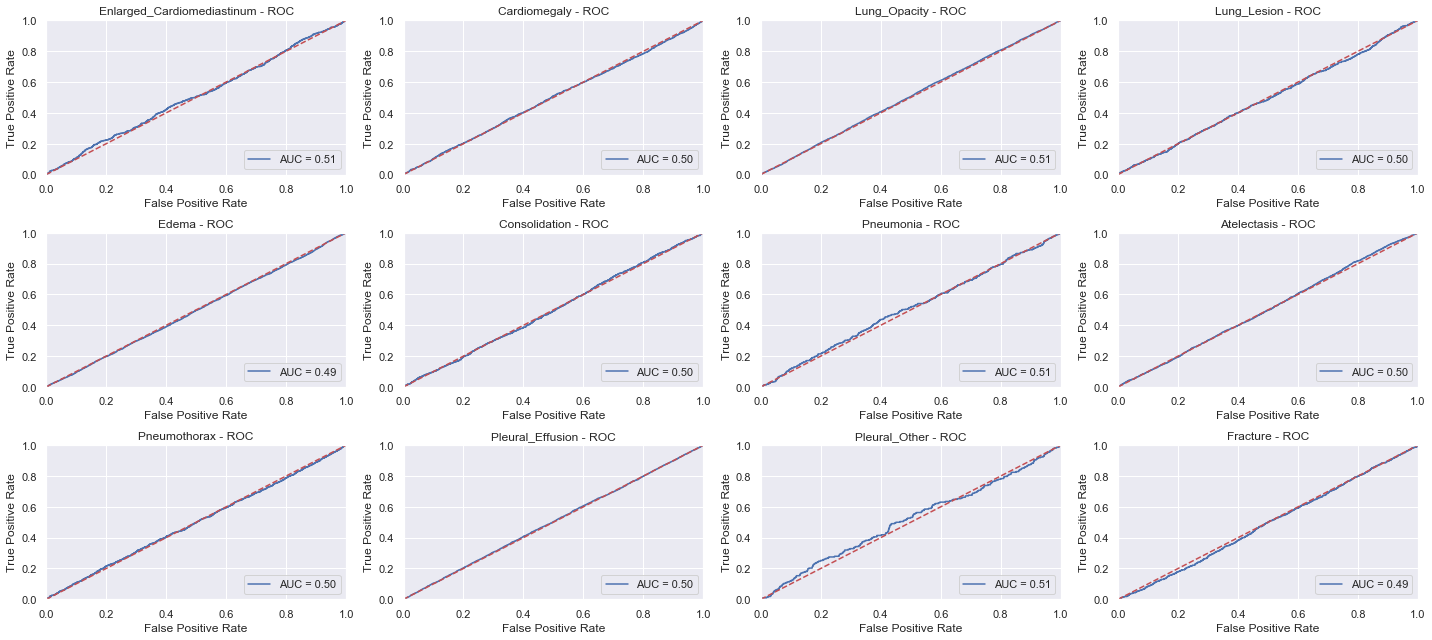

***** Precision / Recall *****


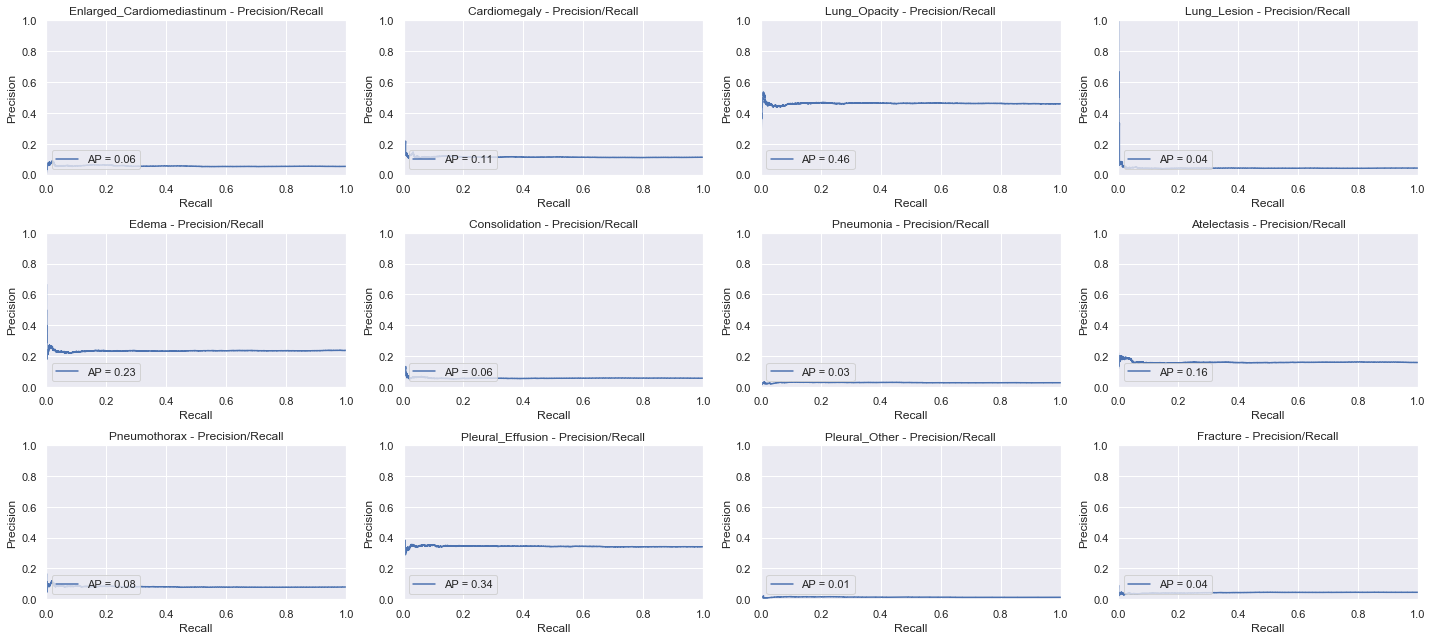


VALIDATION



,Score for all Targets
Accuracy Score,0.008693
Hamming Loss,0.357294
Combined Recall,0.473894
Combined Precision,0.209672
Combined F1,0.272257


,Target,True Positive Count,Recall,Precision,F1,ROC AUC,Avg Precision
0,Enlarged_Cardiomediastinum,135,0.192593,0.038462,0.064118,0.494424,0.043352
1,Cardiomegaly,324,0.888889,0.111498,0.198142,0.553191,0.128757
2,Lung_Opacity,1357,0.711864,0.479881,0.573294,0.544408,0.482353
3,Lung_Lesion,135,0.037037,0.032680,0.034722,0.565570,0.056353
4,Edema,729,0.659808,0.286310,0.399336,0.596322,0.301639
5,Consolidation,211,0.815166,0.069104,0.127407,0.458525,0.062549
6,Pneumonia,86,0.220930,0.034991,0.060413,0.483897,0.028919
7,Atelectasis,497,0.185111,0.135493,0.156463,0.463926,0.149585
8,Pneumothorax,249,0.108434,0.075630,0.089109,0.555979,0.096764
9,Pleural_Effusion,1023,0.859238,0.377091,0.524150,0.577024,0.376115


***** ROC *****


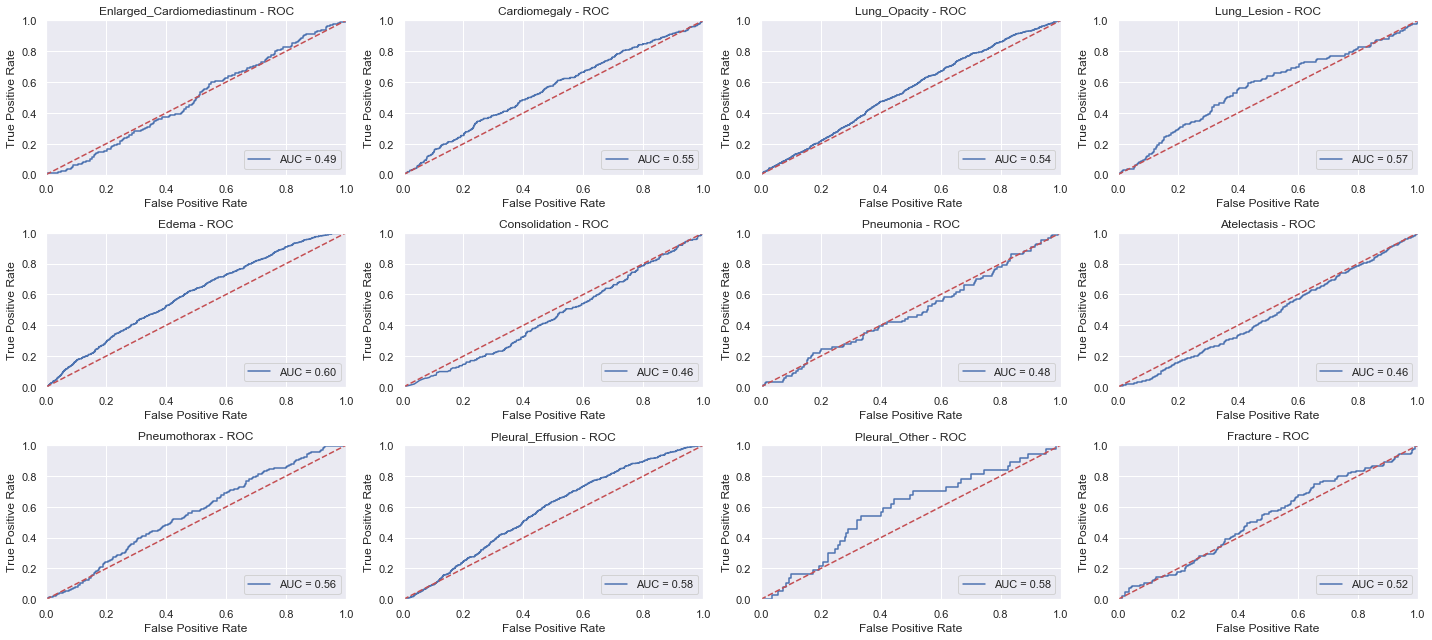

***** Precision / Recall *****


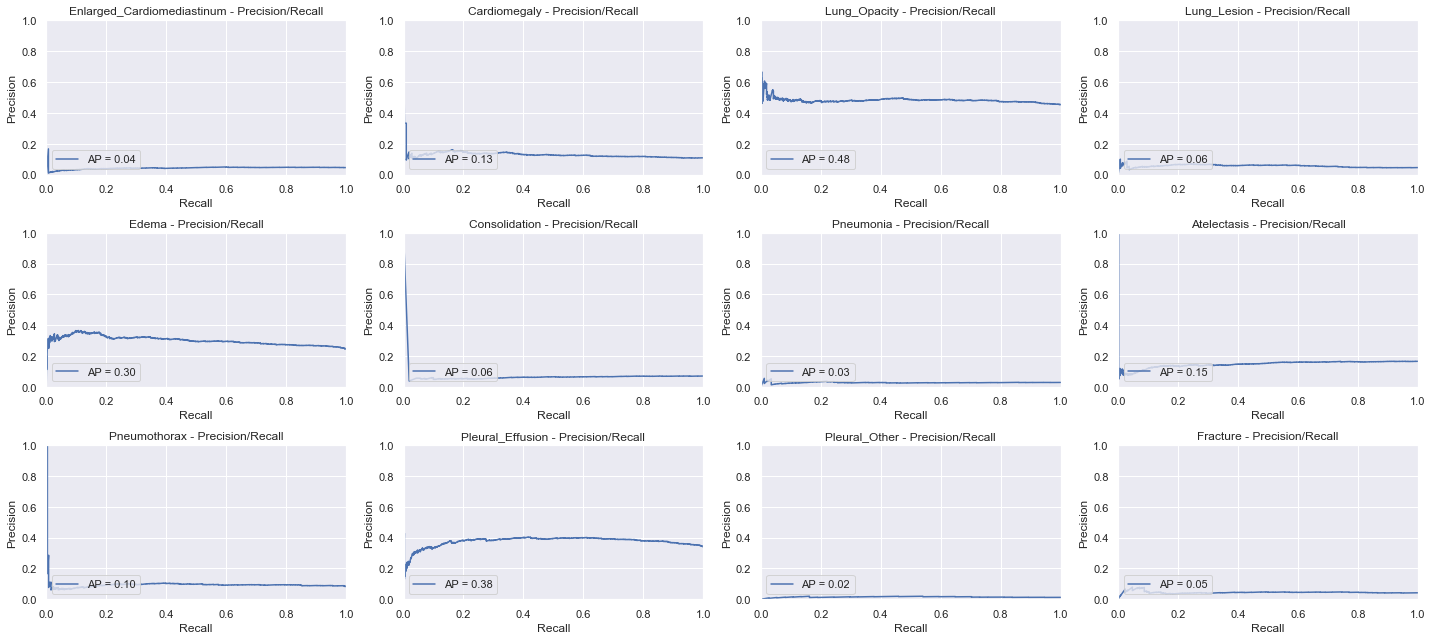

In [13]:
metrics.displayMetrics()

## Results

Since the model was not expected to do better than a 50/50 chance, the final metric output looks good.

One of the best indicators of the 50/50 model is the ROC curves.  For training, all the curves are on the diagonal.

Also, the P/R curves do not look like P/R curves.  In fact, the Average Precision approximates the ground truth positive percentages.
